In [51]:
import numpy as np 
import pandas as pd 
from sklearn.utils import shuffle
import re
import random
import matplotlib.pyplot as plt
import sys

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
df = pd.read_csv('/kaggle/input/kullanlcaklar/Womens_Clothing_E-Commerce_Reviews_1.csv')
df.head()

,Title,Rating
0,"Too boxy, sizing down - not good!",1
1,Bad fit and bad construction,1
2,"Adorable and comfortable, poor fabric quality",1
3,"Really wanted to like it, but...",1
4,Fell apart after 3 wearings,1


In [54]:
#datanın sırasını randomlaştırma
df = shuffle(df)
df = df.reset_index(drop=True)
df.head()

,Title,Rating
0,Everything i'd hoped.,5
1,Cute cover-up or summer top & shorts!,5
2,"Cheap, thin fabric. too bad.",1
3,Super cropped sweater,1
4,"Lovely on the model, but not for me",1


In [55]:
# Genetik algoritma parametreleri ( el ile bir kaç farklı parametre denemesi sonucunda en iyi sonucu aldığımız parametreler)
N = 10 
population_size = 100
mutation_rate = 0.3 
mutation_rate2 = 0.4
generations = 200
generations2 = 150

In [56]:
def grid_search():    # her bir veriseti için grid_search çalıştırmak çok uzun sürdüğü için el ile denendi 
    N_values = [10, 20]
    population_size_values = [50, 100]
    mutation_rate_values = [0.1, 0.3]
    generations_values = [100, 200]

    best_params = None
    best_success_rate = 0

    for N in N_values:
        for population_size in population_size_values:
            for mutation_rate in mutation_rate_values:
                for generations in generations_values:
                    success_rates, average_success_rates = run_genetic_algorithm(N, population_size, mutation_rate, generations)
                    final_success_rate = success_rates[-1]
                    if final_success_rate > best_success_rate:
                        best_success_rate = final_success_rate
                        best_params = (N, population_size, mutation_rate, generations)

    return best_params

In [57]:
text_column_name = 'Title'
rating_column_name = 'Rating'

In [58]:
# verisetindeki noktalama işaretlerini ve stopwordsleri silme
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

def tokenize(text):
    return text.split()

In [59]:
def prepare_population(df, text_column_name):
    all_words = []
    for text in df[text_column_name]:
        clean_review = clean_text(text)
        tokens = tokenize(clean_review)
        all_words.extend(tokens)

    random.shuffle(all_words)

    sublists = [all_words[i:i + N] for i in range(0, len(all_words), N)]

    population = sublists
    return population, all_words

In [60]:
def count_words(text, word_list):
    count = 0
    for word in word_list:
        count += text.count(word)
    return count

In [61]:
def fitness(individual):
    correct_classification = 0
    for i in range(len(df)):
        row = df.iloc[i]
        text, rating = row[text_column_name], row[rating_column_name]
        pozitif = count_words(text, individual[:N // 2])
        negatif = count_words(text, individual[N // 2:])
        #sayılar eşitse rastgele
        if pozitif == negatif:
            if random.random() < 0.5:
                classification = 1
            else:
                classification = 5
        else:
            if pozitif > negatif:
                classification = 5
            else:
                classification = 1
        # sınıflandırma doğruysa
        if classification == rating:
            correct_classification += 1
    # doğru sınıflandırma oranı 
    return correct_classification / len(df)


In [62]:
def fitness2(individual):
    correct_classification = 0
    for i in range(len(df)):
        row = df.iloc[i]
        text, rating = row[text_column_name], row[rating_column_name]
        pozitif = count_words(text, individual[:N // 2])
        negatif = count_words(text, individual[N // 2:])
        #sayılar eşitse rastgele
        if pozitif == negatif:
            if random.random() < 0.5:
                classification = 'negative'
            else:
                classification = 'positive'
        else:
            if pozitif > negatif:
                classification = 'positive'
            else:
                classification = 'negative'
        # sınıflandırma doğruysa
        #print(f"Actual: {rating}, Predicted: {classification}")  # Debugging için
        if classification == rating:
            correct_classification += 1
    # doğru sınıflandırma oranı 
    return correct_classification / len(df)

In [63]:
def crossover(parent1, parent2):
    n = N // 2
    # p1 ilk yarısı p2 2. yarısı 
    child1 = parent1[:n] + parent2[n:]
    # p1 ikinci yarısı p2 ilk yarısı 
    child2 = parent2[:n] + parent1[n:]
    return child1, child2

In [15]:
def mutate(individual, all_words):
    if random.random() < mutation_rate:
        i = random.randint(0, len(individual) - 1)
        new_word = random.choice(all_words)
        individual[i] = new_word
    return individual

In [64]:
def mutate2(individual, all_words):
    if random.random() < mutation_rate2:
        i = random.randint(0, len(individual) - 1)
        new_word = random.choice(all_words)
        individual[i] = new_word
    return individual

In [65]:
def display_results(population, success_rates, average_success_rates):
    best_individual = max(population, key=fitness)
    print("En iyi birey:", best_individual)
    print("Başarı oranı:", fitness(best_individual))

    fig, ax = plt.subplots()
    ax.plot(success_rates, label="En iyi birey")
    ax.plot(average_success_rates, label="Ortalama başarı")
    ax.set_xlabel('Generation')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate per Generation')
    ax.legend()

    plt.show()



In [66]:
def display_results2(population, success_rates, average_success_rates):
    best_individual = max(population, key=fitness2)
    print("En iyi birey:", best_individual)
    print("Başarı oranı:", fitness2(best_individual))

    fig, ax = plt.subplots()
    ax.plot(success_rates, label="En iyi birey")
    ax.plot(average_success_rates, label="Ortalama başarı")
    ax.set_xlabel('Generation')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate per Generation')
    ax.legend()

    plt.show()

In [67]:
population, all_words = prepare_population(df, text_column_name)
print(population)

[['and', 'first', 'worst', 'without', 'elegant', 'like', 'dress', 'just', 'for', 'try'], ['a', 'dress', 'flattering', 'a', 'top', 'too', 'i', 'poor', 'through', 'tent'], ['but', 'very', 'these', 'quality', 'website', 'basic', 'it', 'very', 'and', 'super'], ['timeless', 'surprised', 'shorts', 'look', 'tall', 'this', 'for', 'what', 'younger', 'colorful'], ['and', 'love', 'gorgeous', 'me', 'sherpa', 'really', 'it', 'cute', 'flattering', 'listen'], ['online', 'it', 'if', 'but', 'zipper', 'you', 'is', 'beautiful', 'pop', 'and'], ['larger', 'message', 'perfect', 'construction', 'and', 'flattering', 'blazer', 'run', 'style', 'from'], ['design', 'dont', 'history', 'apart', 'ooooo', 'and', 'rocks', 'shirt', 'expected', 'then'], ['doesnt', 'is', 'perfect', 'adorable', 'my', 'a', 'cute', 'the', 'bad', 'like'], ['on', 'day', 'and', 'they', 'but', 'apart', 'pattern', 'love', 'it', 'unflattering'], ['so', 'excited', 'and', 'was', 'plaid', 'bad', 'was', 'and', 'is', 'hoped'], ['dress', 'fits', 'up', 

In [18]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

En iyi birey: ['wear', 'and', 'super', 'me', 'boxy', 'pretty', 'it', 'and', 'love', 'looks']
Başarı oranı: 0.56


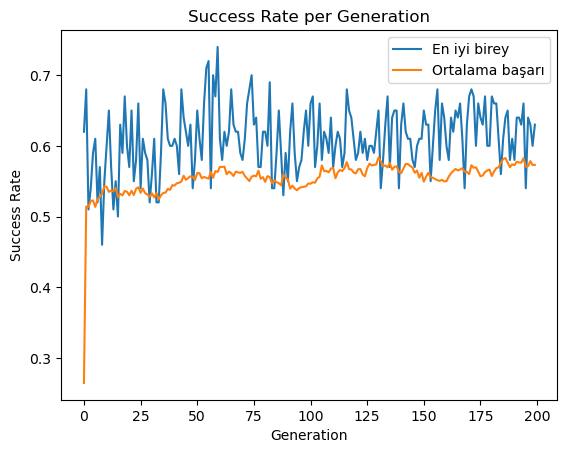

In [20]:
display_results(population, success_rates, average_success_rates) #generations = 200 ve mutate_rate= 0.3 iken

In [68]:
# Başarı oranları ve ortalama başarı oranları için listeler   (burdaki adımla generations sayısını 150 ye düşürerek mutation rate 0.4 yaptık )
success_rates = []
average_success_rates = []

for generation in range(generations2):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate2(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.59
Generation 1: Success Rate: 0.55
Generation 2: Success Rate: 0.48
Generation 3: Success Rate: 0.57
Generation 4: Success Rate: 0.56
Generation 5: Success Rate: 0.55
Generation 6: Success Rate: 0.6
Generation 7: Success Rate: 0.55
Generation 8: Success Rate: 0.59
Generation 9: Success Rate: 0.53
Generation 10: Success Rate: 0.58
Generation 11: Success Rate: 0.52
Generation 12: Success Rate: 0.44
Generation 13: Success Rate: 0.62
Generation 14: Success Rate: 0.52
Generation 15: Success Rate: 0.59
Generation 16: Success Rate: 0.52
Generation 17: Success Rate: 0.67
Generation 18: Success Rate: 0.56
Generation 19: Success Rate: 0.54
Generation 20: Success Rate: 0.51
Generation 21: Success Rate: 0.59
Generation 22: Success Rate: 0.52
Generation 23: Success Rate: 0.63
Generation 24: Success Rate: 0.63
Generation 25: Success Rate: 0.61
Generation 26: Success Rate: 0.67
Generation 27: Success Rate: 0.62
Generation 28: Success Rate: 0.6
Generation 29: Success Rat

En iyi birey: ['the', 'with', 'and', 'me', 'sack', 'uncomfortable', 'on', 'it', 'my', 'not']
Başarı oranı: 0.67


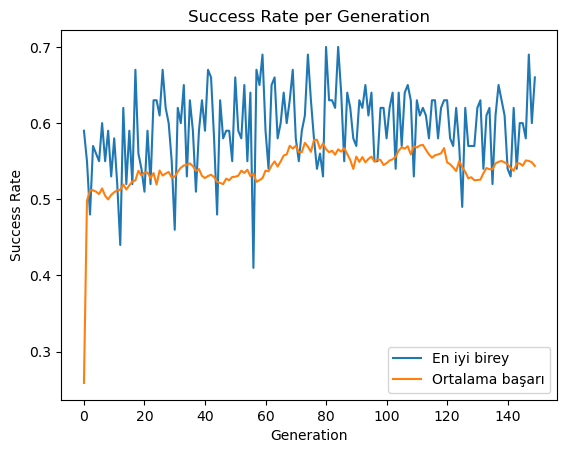

In [69]:
display_results(population, success_rates, average_success_rates) # generation=150 ve mutate_rate 0.4 iken 

In [70]:
df = pd.read_csv('/kaggle/input/kullanlcaklar/amazon_musical_reviews.csv')
text_column_name = 'reviewText'
rating_column_name = 'overall'

In [24]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)


En iyi birey: ['please', 'day', 'flattering', 'and', 'great', 'thin', 'cheap', 'more', 'not', 'other']
Başarı oranı: 0.76


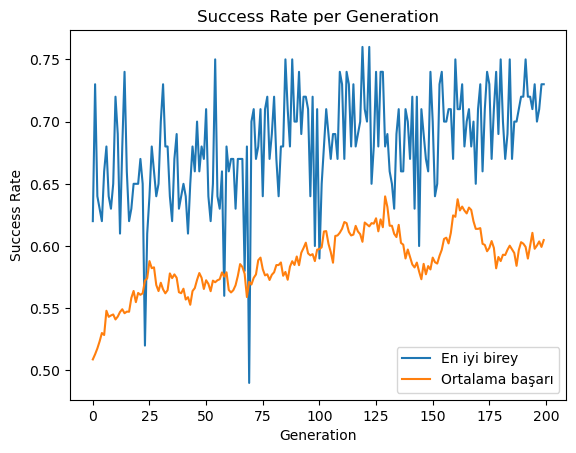

In [25]:
display_results(population, success_rates, average_success_rates) # generations=200 ve mutate_rate=0.3 

In [71]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations2):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate2(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.65
Generation 1: Success Rate: 0.67
Generation 2: Success Rate: 0.61
Generation 3: Success Rate: 0.71
Generation 4: Success Rate: 0.68
Generation 5: Success Rate: 0.65
Generation 6: Success Rate: 0.61
Generation 7: Success Rate: 0.6
Generation 8: Success Rate: 0.63
Generation 9: Success Rate: 0.68
Generation 10: Success Rate: 0.67
Generation 11: Success Rate: 0.73
Generation 12: Success Rate: 0.65
Generation 13: Success Rate: 0.6
Generation 14: Success Rate: 0.7
Generation 15: Success Rate: 0.66
Generation 16: Success Rate: 0.63
Generation 17: Success Rate: 0.68
Generation 18: Success Rate: 0.71
Generation 19: Success Rate: 0.67
Generation 20: Success Rate: 0.6
Generation 21: Success Rate: 0.72
Generation 22: Success Rate: 0.67
Generation 23: Success Rate: 0.7
Generation 24: Success Rate: 0.73
Generation 25: Success Rate: 0.69
Generation 26: Success Rate: 0.76
Generation 27: Success Rate: 0.74
Generation 28: Success Rate: 0.77
Generation 29: Success Rate: 

En iyi birey: ['this', 'the', 'fabric', 'for', 'tentlike', 'really', 'too', 'highly', 'in', 'bad']
Başarı oranı: 0.68


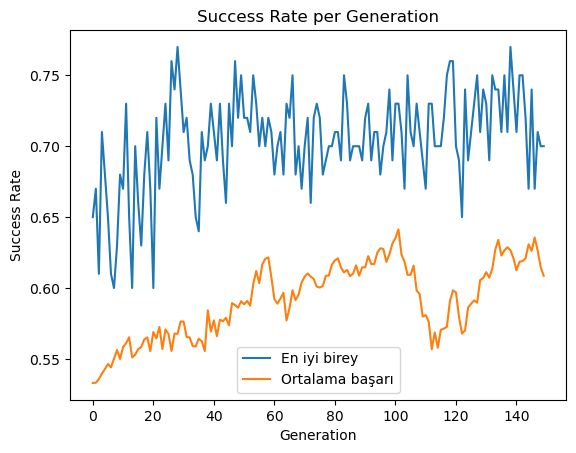

In [72]:
display_results(population, success_rates, average_success_rates) # generations= 150 ve mutate_rate=0.4 

In [73]:
df = pd.read_csv('/kaggle/input/kullanlcaklar/food_taste.csv')
text_column_name = 'Text'
rating_column_name = 'Score'

In [74]:
population, all_words = prepare_population(df, text_column_name)

In [31]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)

En iyi birey: ['which', 'claimbr', 'hairball', 'at', 'them', 'often', 'the', 'product', 'upcbr', 'bought']
Başarı oranı: 0.65


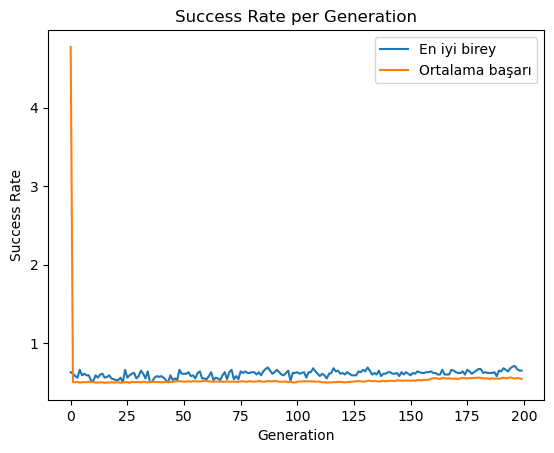

In [32]:
display_results(population, success_rates, average_success_rates) # generations=200 ve mutate_rate=0.3 

In [75]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations2):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate2(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.63
Generation 1: Success Rate: 0.59
Generation 2: Success Rate: 0.67
Generation 3: Success Rate: 0.63
Generation 4: Success Rate: 0.55
Generation 5: Success Rate: 0.62
Generation 6: Success Rate: 0.55
Generation 7: Success Rate: 0.5
Generation 8: Success Rate: 0.58
Generation 9: Success Rate: 0.63
Generation 10: Success Rate: 0.66
Generation 11: Success Rate: 0.59
Generation 12: Success Rate: 0.62
Generation 13: Success Rate: 0.64
Generation 14: Success Rate: 0.65
Generation 15: Success Rate: 0.64
Generation 16: Success Rate: 0.67
Generation 17: Success Rate: 0.68
Generation 18: Success Rate: 0.63
Generation 19: Success Rate: 0.68
Generation 20: Success Rate: 0.64
Generation 21: Success Rate: 0.68
Generation 22: Success Rate: 0.67
Generation 23: Success Rate: 0.65
Generation 24: Success Rate: 0.6
Generation 25: Success Rate: 0.62
Generation 26: Success Rate: 0.64
Generation 27: Success Rate: 0.61
Generation 28: Success Rate: 0.66
Generation 29: Success Rat

En iyi birey: ['away', 'mine', 'recommend', 'and', 'popcorn', 'enough', 'the', '25', 'purchased', 'box']
Başarı oranı: 0.67


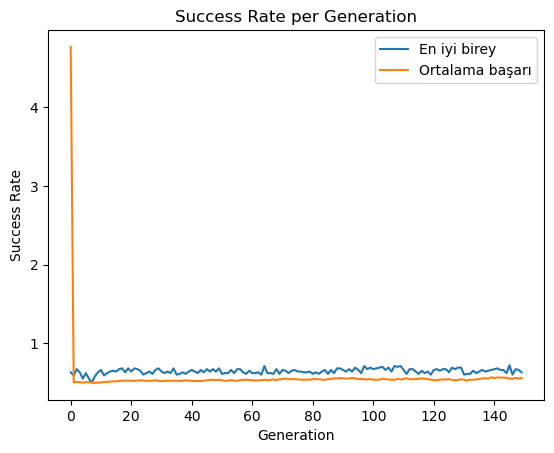

In [76]:
display_results(population, success_rates, average_success_rates) # generations=150 ve mutate_rate=0.4 

In [77]:
df = pd.read_csv('/kaggle/input/kullanlcaklar/imdb_rev.csv')
text_column_name = 'review'
rating_column_name = 'sentiment'
df.head()

,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


In [78]:
population, all_words = prepare_population(df, text_column_name)

In [24]:

# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []
for generation in range(generations):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness2(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness2)
    success_rate = fitness2(best_individual)
    success_rates.append(success_rate)
    #print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.62
Generation 1: Success Rate: 0.58
Generation 2: Success Rate: 0.59
Generation 3: Success Rate: 0.59
Generation 4: Success Rate: 0.6
Generation 5: Success Rate: 0.62
Generation 6: Success Rate: 0.6
Generation 7: Success Rate: 0.58
Generation 8: Success Rate: 0.6
Generation 9: Success Rate: 0.58
Generation 10: Success Rate: 0.62
Generation 11: Success Rate: 0.6
Generation 12: Success Rate: 0.6
Generation 13: Success Rate: 0.6
Generation 14: Success Rate: 0.55
Generation 15: Success Rate: 0.6
Generation 16: Success Rate: 0.58
Generation 17: Success Rate: 0.59
Generation 18: Success Rate: 0.57
Generation 19: Success Rate: 0.6
Generation 20: Success Rate: 0.57
Generation 21: Success Rate: 0.53
Generation 22: Success Rate: 0.58
Generation 23: Success Rate: 0.61
Generation 24: Success Rate: 0.59
Generation 25: Success Rate: 0.58
Generation 26: Success Rate: 0.59
Generation 27: Success Rate: 0.57
Generation 28: Success Rate: 0.55
Generation 29: Success Rate: 0.6

En iyi birey: ['from', 'and', 'who', 'put', 'wants', 'think', 'movie', 'br', 'shot', 'identify']
Başarı oranı: 0.72


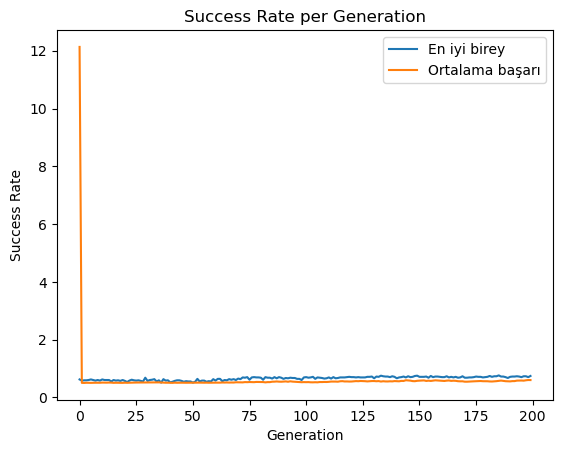

In [26]:
display_results2(population, success_rates, average_success_rates) # generations=200 ve mutate_rate=0.3 

In [79]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []
for generation in range(generations2):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness2(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate2(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness2)
    success_rate = fitness2(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.63
Generation 1: Success Rate: 0.6
Generation 2: Success Rate: 0.67
Generation 3: Success Rate: 0.63
Generation 4: Success Rate: 0.57
Generation 5: Success Rate: 0.65
Generation 6: Success Rate: 0.61
Generation 7: Success Rate: 0.61
Generation 8: Success Rate: 0.67
Generation 9: Success Rate: 0.58
Generation 10: Success Rate: 0.6
Generation 11: Success Rate: 0.67
Generation 12: Success Rate: 0.63
Generation 13: Success Rate: 0.66
Generation 14: Success Rate: 0.67
Generation 15: Success Rate: 0.59
Generation 16: Success Rate: 0.66
Generation 17: Success Rate: 0.66
Generation 18: Success Rate: 0.61
Generation 19: Success Rate: 0.63
Generation 20: Success Rate: 0.64
Generation 21: Success Rate: 0.61
Generation 22: Success Rate: 0.66
Generation 23: Success Rate: 0.65
Generation 24: Success Rate: 0.68
Generation 25: Success Rate: 0.71
Generation 26: Success Rate: 0.64
Generation 27: Success Rate: 0.62
Generation 28: Success Rate: 0.68
Generation 29: Success Rat

En iyi birey: ['makebr', 'do', 'and', 'brothers', 'and', 'they', 'is', 'tis', 'br', 'kill']
Başarı oranı: 0.69


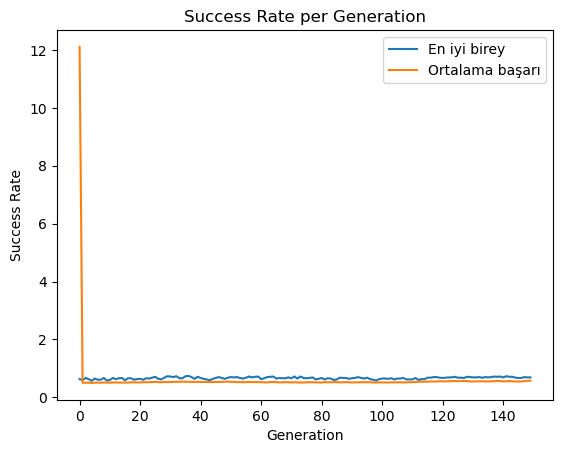

In [80]:
display_results2(population, success_rates, average_success_rates) # generations=150 ve mutate_rate=0.4 

In [45]:
df = pd.read_csv('/kaggle/input/kullanlcaklar/twitter100.csv')
df.head()

,target,text
0,0,@Nkluvr4eva My poor little dumpling In Holmde...
1,0,I'm off too bed. I gotta wake up hella early t...
2,0,I havent been able to listen to it yet My spe...
3,0,now remembers why solving a relatively big equ...
4,0,"Ate too much, feel sick"


In [46]:
df['target'] = df['target'].replace({4: 5, 0: 1})
df['target'] = df['target'].astype(str)
df.head()

,target,text
0,1,@Nkluvr4eva My poor little dumpling In Holmde...
1,1,I'm off too bed. I gotta wake up hella early t...
2,1,I havent been able to listen to it yet My spe...
3,1,now remembers why solving a relatively big equ...
4,1,"Ate too much, feel sick"


In [48]:
text_column_name = 'text'
rating_column_name = 'target'

In [49]:
population, all_words = prepare_population(df, text_column_name)

In [50]:
# Başarı oranları ve ortalama başarı oranları için listeler
success_rates = []
average_success_rates = []

for generation in range(generations):
    # fitness değerlerini hesaplama
    fitness_values = []
    for individual in population:
        fitness_values.append(fitness(individual))

    # Ortalama başarı oranını hesapla
    average_success_rate = sum(fitness_values) / population_size
    average_success_rates.append(average_success_rate)

    # rasgele üretilmiş kromozom / durum / çözüm hipotezi
    #parents = random.choices(population, weights=fitness_values, k=2)

    # crossover işlemi
    children = []
    for i in range(population_size // 2):
        parents = random.choices(population, weights=fitness_values, k=2)
        child1, child2 = crossover(parents[0], parents[1])
        children.append(child1)
        children.append(child2)

    # mutasyon işlemi
    mutations = []
    for child in children:
        mutations.append(mutate(child, all_words))
    population = mutations

    # En iyi bireyin başarı oranını kaydet
    best_individual = max(population, key=fitness)
    success_rate = fitness(best_individual)
    success_rates.append(success_rate)
    print(f"Generation {generation}: Success Rate: {success_rate}")

Generation 0: Success Rate: 0.0
Generation 1: Success Rate: 0.0
Generation 2: Success Rate: 0.0
Generation 3: Success Rate: 0.0
Generation 4: Success Rate: 0.0
Generation 5: Success Rate: 0.0
Generation 6: Success Rate: 0.0
Generation 7: Success Rate: 0.0
Generation 8: Success Rate: 0.0
Generation 9: Success Rate: 0.0
Generation 10: Success Rate: 0.0
Generation 11: Success Rate: 0.0
Generation 12: Success Rate: 0.0
Generation 13: Success Rate: 0.0
Generation 14: Success Rate: 0.0
Generation 15: Success Rate: 0.0
Generation 16: Success Rate: 0.0
Generation 17: Success Rate: 0.0
Generation 18: Success Rate: 0.0
Generation 19: Success Rate: 0.0
Generation 20: Success Rate: 0.0
Generation 21: Success Rate: 0.0
Generation 22: Success Rate: 0.0
Generation 23: Success Rate: 0.0
Generation 24: Success Rate: 0.0
Generation 25: Success Rate: 0.0
Generation 26: Success Rate: 0.0
Generation 27: Success Rate: 0.0
Generation 28: Success Rate: 0.0
Generation 29: Success Rate: 0.0
Generation 30: Succe

En iyi birey: ['and', '100', 'i', 'it', 'guys', 'how', 'vimeo']
Başarı oranı: 0.0


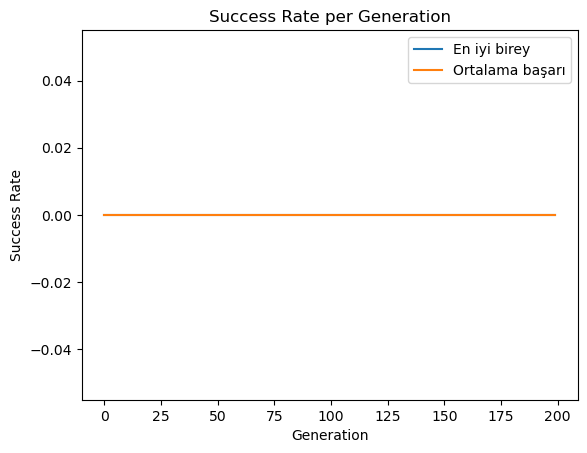

In [39]:
display_results(population, success_rates, average_success_rates)